In [153]:
import pandas as pd
import numpy as np
import math
from scipy import interp
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from pandas.plotting import scatter_matrix
from statsmodels.tools import add_constant
from statsmodels.discrete.discrete_model import Logit

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
# from sklearn.ensemble.partial_dependence import plot_partial_dependence

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, classification_report

In [3]:
data = pd.read_csv(r'/home/ofprogram/Downloads/dataset_diabetes/diabetic_data.csv')

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [202]:
#Pick the features of interest. 
df = data[['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses', 'A1Cresult', 'change', 'diabetesMed',
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']]

#Change 'unknown' to 'other'. 
df['race'] = df['race'].replace(['?'],'Other')

#Define target variable. 
data['readmitted'] = [ 0 if val == 'NO' else 1 for val in data['readmitted']]


/home/ofprogram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [198]:
#Get dummy variables.
X = pd.get_dummies(df, columns=['race', 'gender', 'age', 'admission_type_id', 
    'discharge_disposition_id', 'admission_source_id', 'A1Cresult', 'change', 
    'diabetesMed', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'])

#Drop columns. 
# X = dum.drop(['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
#     'admission_source_id', 'A1Cresult', 'change', 'diabetesMed',
#     'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
#     'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
#     'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
#     'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
#     'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'], axis=1)

#Select target variable.
y = data['readmitted']

# EDA

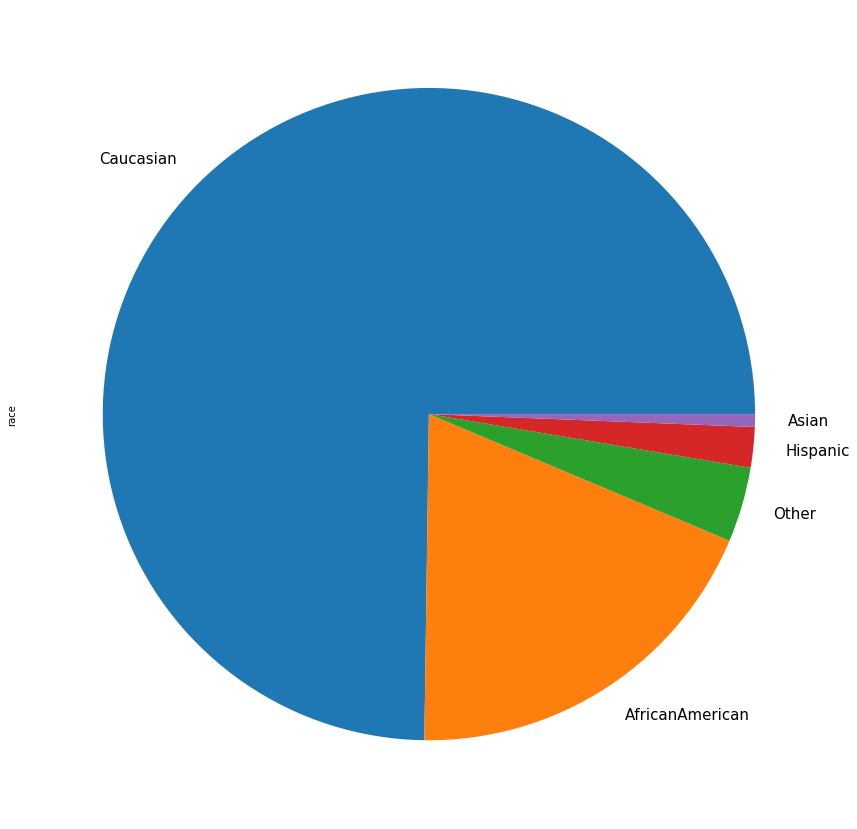

In [146]:
df.race.value_counts().plot(kind='pie', figsize=(15,15), fontsize=(15))

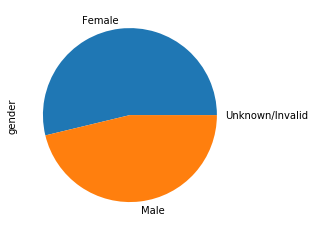

In [55]:
df.gender.value_counts().plot(kind='pie')

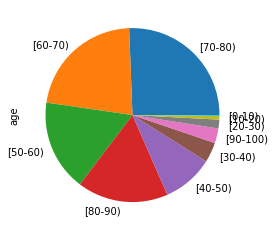

In [56]:
df.age.value_counts().plot(kind='pie')

In [78]:
# def mean_by_age(column):
#     return df[['age', column]].groupby('age').mean().sort_values(by=column)
# print mean_by_age(num_medications)

ave_meds = df[['age', 'num_medications']].groupby('age').mean().sort_values(by='num_medications')
ave_procedures = df[['age', 'num_procedures']].groupby('age').mean().sort_values(by='num_procedures')
ave_lab_procedures = df[['age', 'num_lab_procedures']].groupby('age').mean().sort_values(by='num_lab_procedures')
ave_time_spent = df[['age', 'time_in_hospital']].groupby('age').mean().sort_values(by='time_in_hospital')

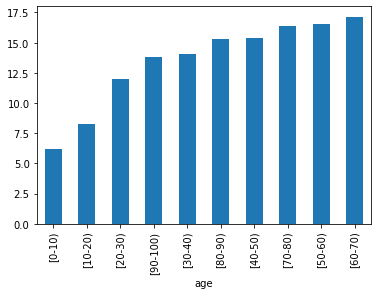

In [79]:
ave_meds.num_medications.plot(kind='bar')

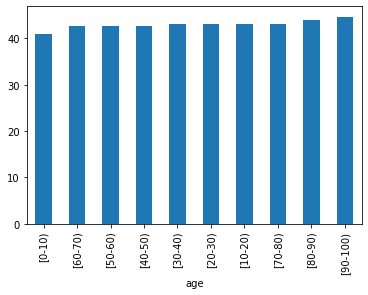

In [80]:
ave_lab_procedures.num_lab_procedures.plot(kind='bar')

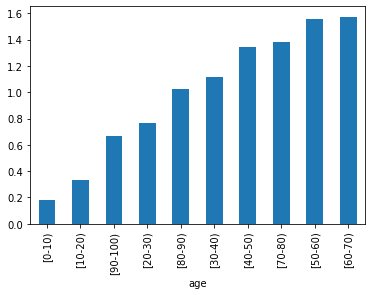

In [81]:
ave_procedures.num_procedures.plot(kind='bar')

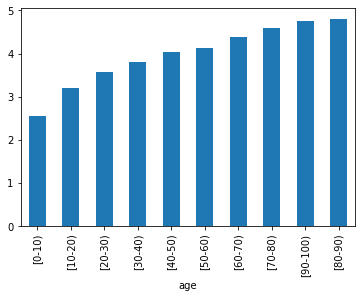

In [82]:
ave_time_spent.time_in_hospital.plot(kind='bar')

# ROC Curves

/home/ofprogram/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


TypeError: unsupported operand type(s) for +: 'int' and 'str'

# ML Models

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [181]:
lr = LogisticRegression()
#max_iter=10000

rf = RandomForestClassifier()
#n_estimators=25, n_jobs=-1, random_state=1

gdbc = GradientBoostingClassifier()
#learning_rate=0.1, n_estimators=25, random_state=1

In [203]:
def class_report(model):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    return classification_report(y_test, prediction)
#accuracy_score(y_test, prediction)
print(class_report(lr))

              precision    recall  f1-score   support

           0       0.63      0.77      0.69      8242
           1       0.63      0.47      0.54      7023

    accuracy                           0.63     15265
   macro avg       0.63      0.62      0.62     15265
weighted avg       0.63      0.63      0.62     15265



/home/ofprogram/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [201]:
print(class_report(rf))

              precision    recall  f1-score   support

           0       0.64      0.71      0.68      8242
           1       0.61      0.54      0.57      7023

    accuracy                           0.63     15265
   macro avg       0.63      0.62      0.62     15265
weighted avg       0.63      0.63      0.63     15265



In [204]:
print(class_report(gdbc))

              precision    recall  f1-score   support

           0       0.64      0.76      0.70      8242
           1       0.64      0.50      0.56      7023

    accuracy                           0.64     15265
   macro avg       0.64      0.63      0.63     15265
weighted avg       0.64      0.64      0.64     15265



AxesSubplot(0.125,0.125;0.775x0.755)


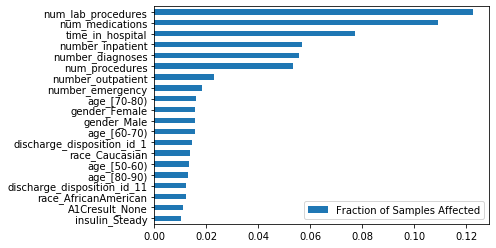

In [176]:
def feat_importance(model): 
    feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_}, index=X.columns)
    feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
    return feat_scores[135:].plot(kind='barh')
print(feat_importance(rf))

AxesSubplot(0.125,0.125;0.775x0.755)


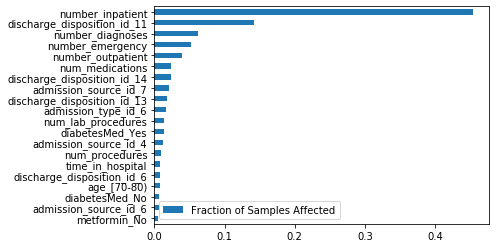

In [177]:
print(feat_importance(gdbc))

/home/ofprogram/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


None


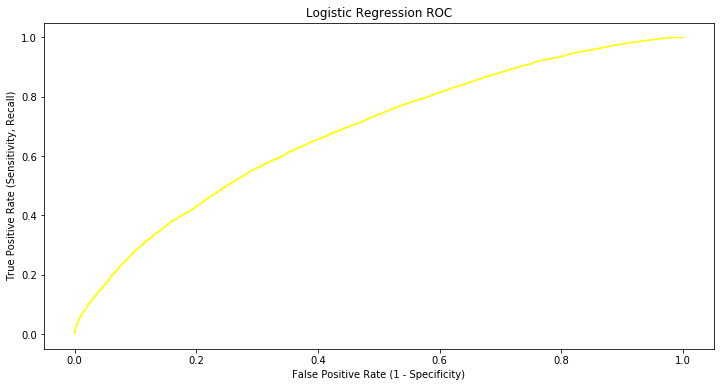

In [200]:
def roc_curve(probabilities, labels):
 
    thresholds = np.sort(probabilities)

    tprs = []
    fprs = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)

    return tprs, fprs, thresholds.tolist()


def run_hosp_data(model):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_test)[:, 1]

    tpr, fpr, thresholds = roc_curve(probabilities, y_test)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(fpr, tpr, color='yellow')
    ax.set_xlabel("False Positive Rate (1 - Specificity)")
    ax.set_ylabel("True Positive Rate (Sensitivity, Recall)")
    ax.set_title("Logistic Regression ROC")


print(run_hosp_data(lr))
